In [2]:
import pandas as pd
import numpy as np
import nltk
import jieba
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [3]:
import nltk

nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Basic text cleaning and tokenization with Jieba
def preprocess_text(text):
    text = str(text)
    # Tokenization with Jieba
    tokens = list(jieba.cut(text))
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [5]:
# Replace NaN values with an empty string
df_train['text'] = df_train['text'].fillna('')
df_test['text'] = df_test['text'].fillna('')

# Apply preprocessing
df_train['tokens'] = df_train['text'].apply(preprocess_text)
df_test['tokens'] = df_test['text'].apply(preprocess_text)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache
Loading model cost 1.986 seconds.
DEBUG:jieba:Loading model cost 1.986 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [6]:
# Concatenate tokens for Word2Vec training
all_tokens = pd.concat([df_train['tokens'], df_test['tokens']], axis=0)

# Train a Word2Vec model or load a pre-trained model
model_w2v = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [7]:
# Function to convert tokens to vectors, using zero vector for unknown words
def tokens_to_vectors(tokens, model):
    vectors = [model.wv[word] if word in model.wv else np.zeros((model.vector_size,)) for word in tokens]
    return np.array(vectors)

In [8]:
# Convert train and test tokens to vectors
df_train['vectors'] = df_train['tokens'].apply(lambda tokens: tokens_to_vectors(tokens, model_w2v))
df_test['vectors'] = df_test['tokens'].apply(lambda tokens: tokens_to_vectors(tokens, model_w2v))

In [9]:
df_train['vectors'][0]

array([[-0.22978902,  0.48867536,  0.5062609 , ..., -0.90104365,
         0.06040232,  0.25492725],
       [ 0.27436402,  0.5703138 ,  1.3367038 , ..., -0.6505052 ,
        -0.28517103,  0.67444456],
       [ 0.04993254,  1.5402592 ,  0.20402983, ..., -1.4337877 ,
        -0.01354039, -0.27573684],
       ...,
       [-0.22978902,  0.48867536,  0.5062609 , ..., -0.90104365,
         0.06040232,  0.25492725],
       [-0.22978902,  0.48867536,  0.5062609 , ..., -0.90104365,
         0.06040232,  0.25492725],
       [-0.61546016,  0.2040252 ,  0.6684235 , ..., -0.8104352 ,
         0.10982911,  0.36756074]], dtype=float32)

In [66]:
# Find the maximum sequence length to use for padding
max_seq_length = max(df_train['vectors'].apply(len).max(), df_test['vectors'].apply(len).max())

In [11]:
# Pad sequences
X_train_padded = pad_sequences(df_train['vectors'].tolist(), maxlen=max_seq_length, dtype='float32', padding='post')
X_test_padded = pad_sequences(df_test['vectors'].tolist(), maxlen=max_seq_length, dtype='float32', padding='post')

In [12]:
# Convert sentiment labels to numerical values

le= LabelEncoder()
df_train['label']= le.fit_transform(df_train['sentiment'])
y_train = df_train['label'].values
df_test['label'] = le.transform(df_test['sentiment'])
y_test= df_test['label'].values

In [16]:
X_train_padded, X_val, y_train, y_val = train_test_split(X_train_padded, y_train, test_size=0.2)
## X_val_padded, X_test_padded, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [17]:
embedding_dim = model_w2v.vector_size
input_layer = Input(shape=(max_seq_length, embedding_dim))
attention_out = MultiHeadAttention(num_heads=2, key_dim=embedding_dim, value_dim=embedding_dim)(query=input_layer, key=input_layer, value=input_layer)

# TextCNN
conv1 = Conv1D(filters=250, kernel_size=3, activation='relu')(attention_out)
conv2 = Conv1D(filters=100, kernel_size=4, activation='relu')(attention_out)
conv3 = Conv1D(filters=50, kernel_size=5, activation='relu')(attention_out)

pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)
pool3 = GlobalMaxPooling1D()(conv3)

concatenated = Concatenate()([pool1, pool2, pool3])

# Apply Dropout for regularization
dropout_rate = 0.5
dropout_layer = Dropout(rate=dropout_rate)(concatenated)

# Fully connected layer with batch normalization
dense_units = 512
dense_layer = Dense(units=dense_units, activation='relu', kernel_regularizer=l2(0.01))(dropout_layer)
batch_norm_layer = BatchNormalization()(dense_layer)

# Output layer
output_layer = Dense(units=3, activation='softmax')(batch_norm_layer)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_padded, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))
#history = model.fit(X_train_padded, y_train, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
550/550 [==============================] - 9s 12ms/step - loss: 1.8141 - accuracy: 0.4414 - val_loss: 1.2064 - val_accuracy: 0.4221
Epoch 2/50
550/550 [==============================] - 5s 9ms/step - loss: 1.0470 - accuracy: 0.4986 - val_loss: 1.0481 - val_accuracy: 0.4794
Epoch 3/50
550/550 [==============================] - 5s 10ms/step - loss: 0.9919 - accuracy: 0.5431 - val_loss: 1.0075 - val_accuracy: 0.4605
Epoch 4/50
550/550 [==============================] - 5s 9ms/step - loss: 0.9445 - accuracy: 0.5696 - val_loss: 0.9558 - val_accuracy: 0.5672
Epoch 5/50
550/550 [==============================] - 5s 9ms/step - loss: 0.9259 - accuracy: 0.5792 - val_loss: 1.0610 - val_accuracy: 0.5040
Epoch 6/50
550/550 [==============================] - 5s 10ms/step - loss: 0.9239 - accuracy: 0.5805 - val_loss: 0.9630 - val_accuracy: 0.5549
Epoch 7/50
550/550 [==============================] - 5s 9ms/step - loss: 0.9152 - accuracy: 0.5844 - val_loss: 0.9210 - val_accuracy: 0.5811
Epo

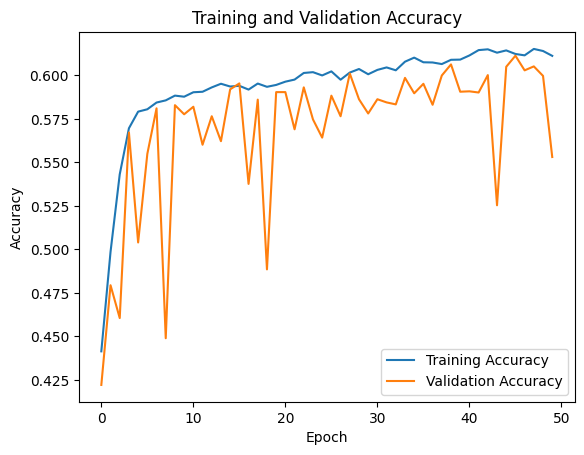

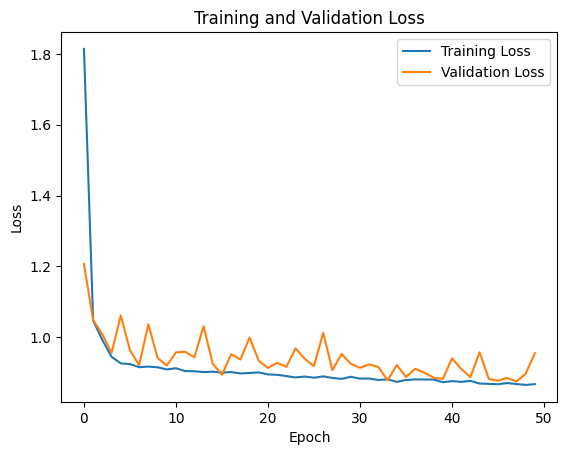

In [18]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

111/111 [==============================] - 1s 4ms/step


<Axes: >

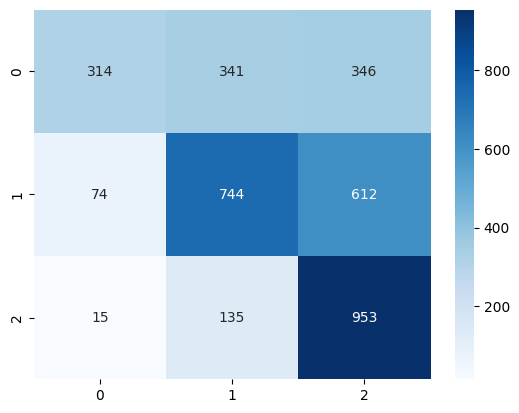

In [19]:
# Evaluate the model
y_pred = np.argmax(model.predict(X_test_padded), axis=-1)

# Metrics and Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

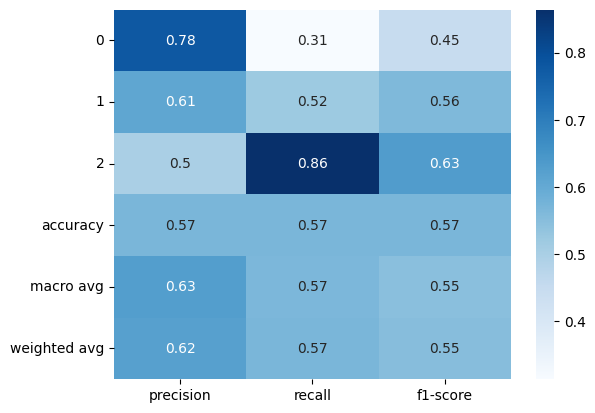

In [20]:
clf_report=classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,  cmap="Blues")
plt.show()

In [108]:
y_test

array([1, 2, 0, ..., 0, 2, 2])

In [21]:
# Convert predicted labels to a DataFrame
df_results = pd.DataFrame({'Text':df_test['text'],
                           'True_Label': le.inverse_transform(y_test),
                           'Predicted_Label': le.inverse_transform(y_pred)})

# Print the DataFrame
df_results

,Text,True_Label,Predicted_Label
0,Last session of the day http://twitpic.com/67ezh,neutral,positive
1,Shanghai is also really exciting (precisely -...,positive,positive
2,"Recession hit Veronique Branquinho, she has to...",negative,positive
3,happy bday!,positive,positive
4,http://twitpic.com/4w75p - I like it!!,positive,neutral
...,...,...,...
3529,"its at 3 am, im very tired but i can`t sleep ...",negative,negative
3530,All alone in this old house again. Thanks for...,positive,positive
3531,I know what you mean. My little dog is sinkin...,negative,neutral
3532,_sutra what is your next youtube video gonna b...,positive,positive


### Input from User

In [79]:
df_results

,Text,True_Label,Predicted_Label
0,Last session of the day http://twitpic.com/67ezh,neutral,positive
1,Shanghai is also really exciting (precisely -...,positive,positive
2,"Recession hit Veronique Branquinho, she has to...",negative,positive
3,happy bday!,positive,positive
4,http://twitpic.com/4w75p - I like it!!,positive,neutral
...,...,...,...
3529,"its at 3 am, im very tired but i can`t sleep ...",negative,negative
3530,All alone in this old house again. Thanks for...,positive,positive
3531,I know what you mean. My little dog is sinkin...,negative,neutral
3532,_sutra what is your next youtube video gonna b...,positive,positive


In [84]:
user_input = input("Enter text: ")
user_tokens = preprocess_text(user_input)

# Convert tokens to vectors using Word2Vec model
user_vectors = tokens_to_vectors(user_tokens, model_w2v)

padded_user_input = pad_sequences([user_vectors], maxlen=max_seq_length, dtype='float32', padding='post')

prediction = model.predict(padded_user_input)
predicted_label = np.argmax(prediction[0], axis=-1)
pred_label= le.inverse_transform(predicted_label)

print("Predicted label:", pred_label)

Enter text: its at 3 am, im very tired but i can`t sleep  but i try it
1/1 [==============================] - 0s 19ms/step
Predicted label: ['negative']


In [76]:
predicted_label

array([2])

In [56]:
padded_text.shape

(14, 124)

In [72]:
df_test['text'][24]

' you are lame  go make me breakfast!!'

111/111 [==============================] - 1s 5ms/step
Overall ROC-AUC Score: 0.7826170707348591


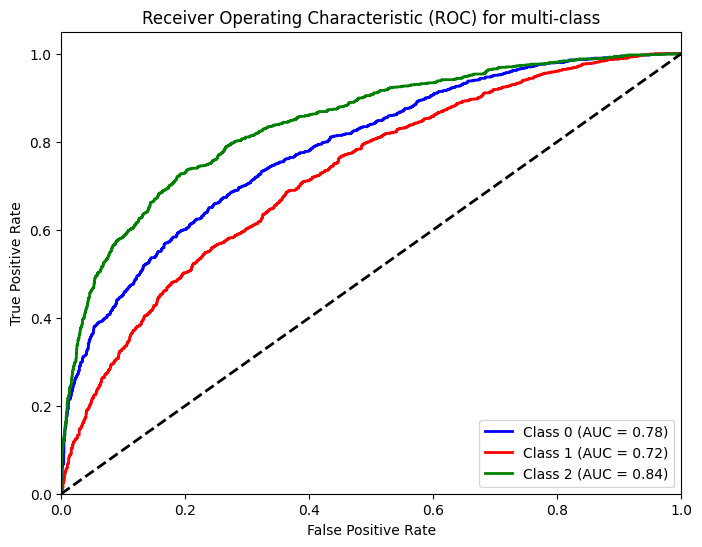

In [22]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Convert y_test to one-hot encoded format if it's not already
if len(y_test.shape) == 1:
    label_binarizer = LabelBinarizer()
    y_test = label_binarizer.fit_transform(y_test)

# Calculate the ROC AUC Score
y_prob = model.predict(X_test_padded)
roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')

print(f"Overall ROC-AUC Score: {roc_auc_ovr}")

# Compute ROC curve and ROC area for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for multi-class')
plt.legend(loc="lower right")
plt.show()

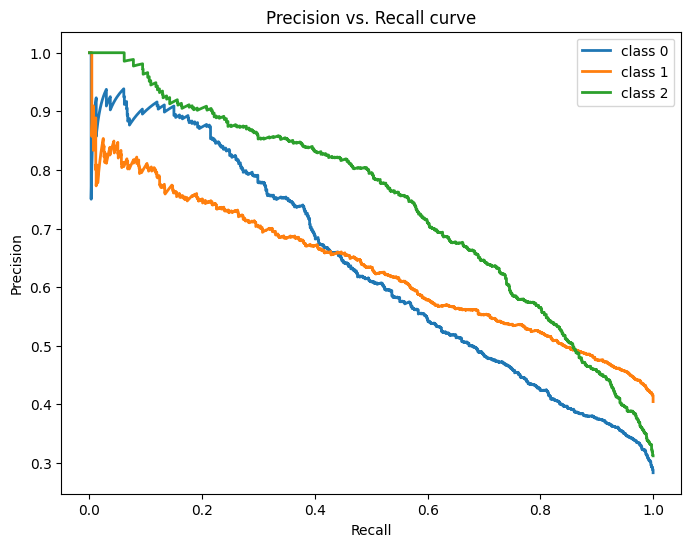

In [23]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


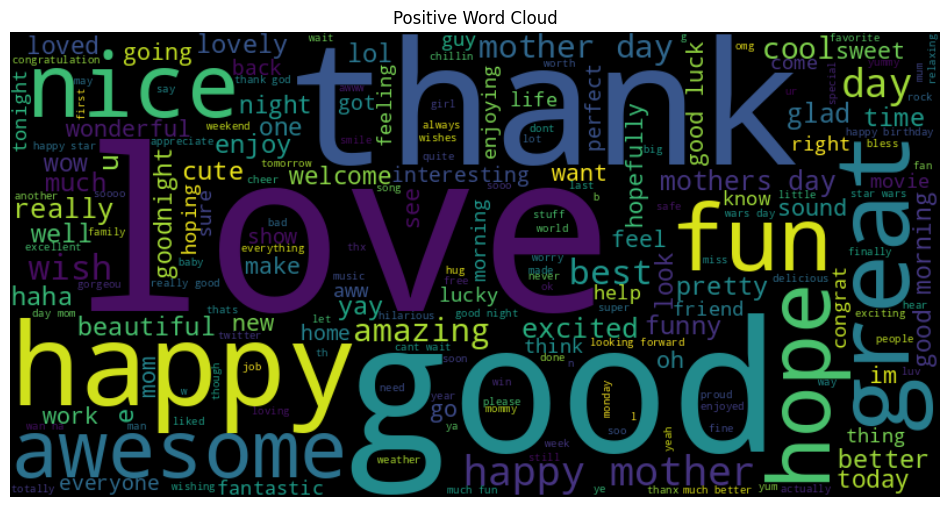

In [24]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
positive_texts = df_train[df_train['sentiment'] == 'positive']['selected_text']
negative_texts = df_train[df_train['sentiment'] == 'negative']['selected_text']
neutral_texts = df_train[df_train['sentiment'] == 'neutral']['selected_text']

# Tokenize and extract words for each sentiment category
positive_words = [word.lower() for text in positive_texts for word in word_tokenize(str(text))]
negative_words = [word.lower() for text in negative_texts for word in word_tokenize(str(text))]
neutral_words = [word.lower() for text in neutral_texts for word in word_tokenize(str(text))]

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
positive_words = [word for word in positive_words if word not in stop_words]
negative_words = [word for word in negative_words if word not in stop_words]
neutral_words = [word for word in neutral_words if word not in stop_words]

def plot_word_cloud(words, title):
    wordcloud = WordCloud(width=800, height=400).generate(' '.join(words))
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_word_cloud(positive_words, 'Positive Word Cloud')

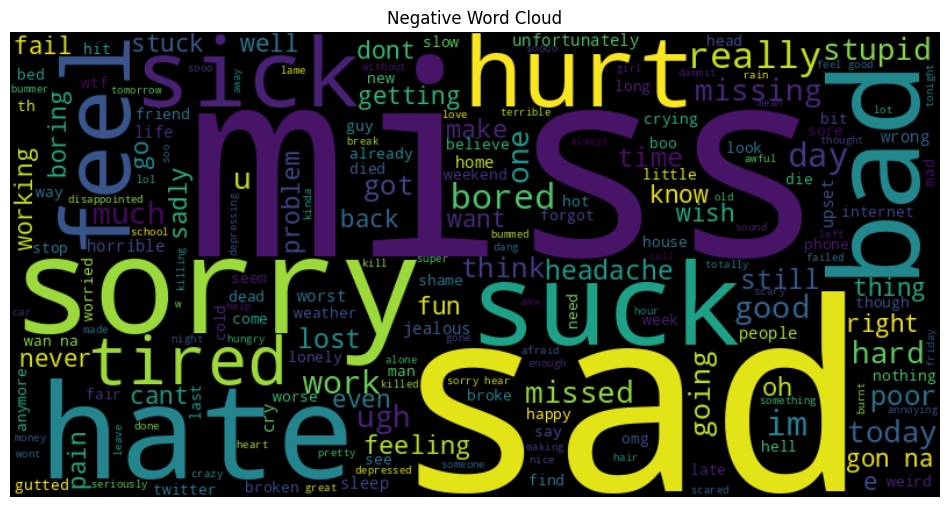

In [25]:
plot_word_cloud(negative_words, 'Negative Word Cloud')

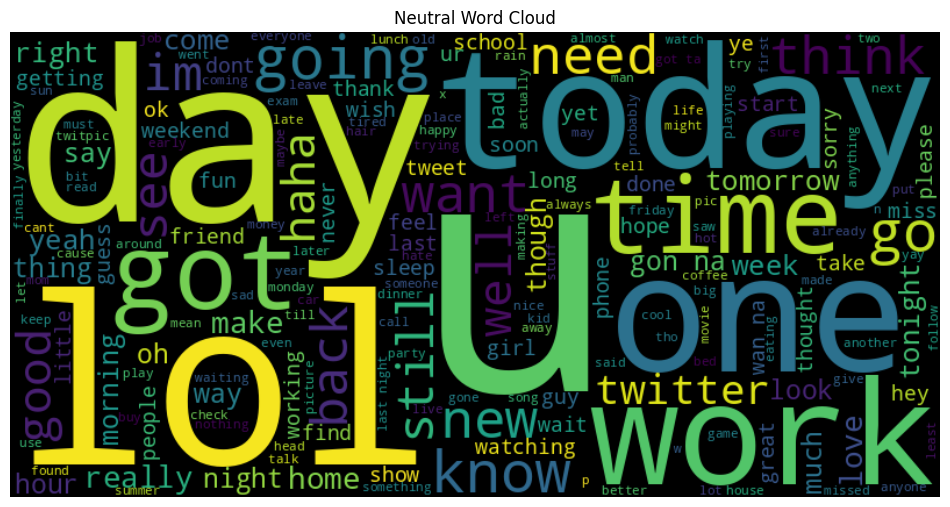

In [26]:
plot_word_cloud(neutral_words, 'Neutral Word Cloud')

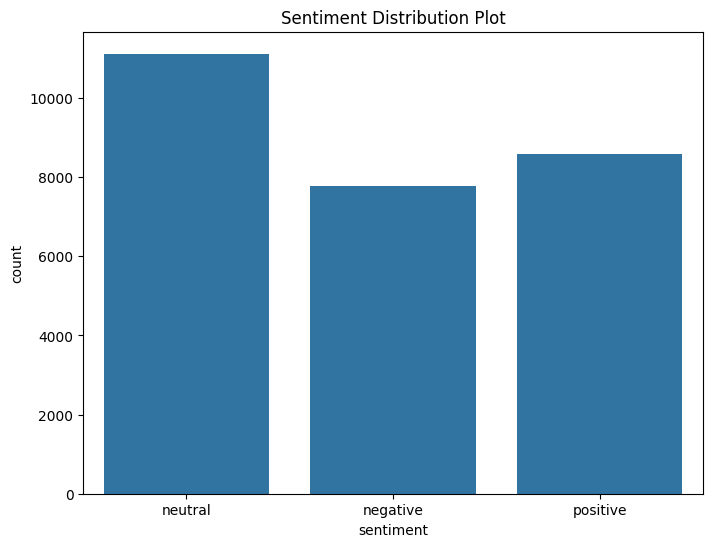

In [27]:
# Sentiment Distribution Plot
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_train)
plt.title('Sentiment Distribution Plot')
plt.show()

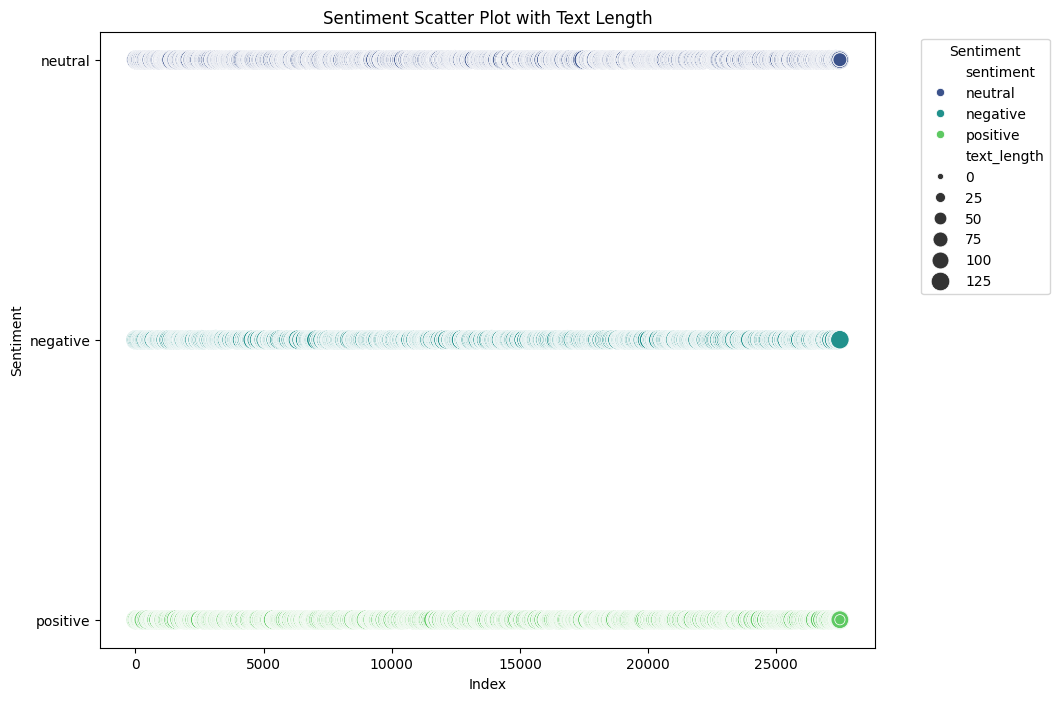

In [28]:
plt.figure(figsize=(10, 8))
df_train['text_length'] = df_train['text'].apply(len)

sns.scatterplot(x=df_train.index, y='sentiment', size='text_length', data=df_train, hue='sentiment', sizes=(20, 200), palette='viridis')
plt.title('Sentiment Scatter Plot with Text Length')
plt.xlabel('Index')
plt.ylabel('Sentiment')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [29]:
model = Model(inputs=input_layer, outputs=[output_layer, attention_out])

In [30]:
prediction, attention_weights = model.predict(X_test_padded)

111/111 [==============================] - 1s 4ms/step


In [31]:
attention_sample = attention_weights[0]

attention_avg = np.mean(attention_sample, axis=0)

# Identify top-k tokens
top_k_indices = np.argsort(attention_avg)[-5:]  # Get indices of top 5 tokens

In [37]:
def highlight_keywords(text_tokens, top_indices):
    flattened_tokens = [token for sublist in text_tokens for token in sublist]
    highlighted_tokens = [f'**{token}**' if idx in top_indices else token for idx, token in enumerate(flattened_tokens)]
    return ' '.join(highlighted_tokens)

highlighted_text = highlight_keywords(df_train['tokens'], top_k_indices)
print(highlighted_text)

  I `     responded ,     I     going   Sooo   SAD   I     miss     ** **   San ** ** Diego **!** ! !   boss     bullying   ...     interview ! ** ** leave     alone   Sons     * * * * , ** **   `     put         releases     already   bought http : / / www . dothebouncy . com / smf   -     shameless   plugging       best   Rangers   forum     earth 2am   feedings       baby     fun           smiles     coos Soooo   high   Both       Journey ! ?   Wow ...   u     became   cooler .     hehe ...   (     possible ! ? )     much       love       hopeful ,     reckon     chances     minimal   = P   `   never   gonna   get     cake     stuff I   really   really   like     song   Love   Story     Taylor   Swift My   Sharpie     running   DANGERously   low     ink   want     go     music   tonight       lost     voice . test   test       LG   enV2 Uh   oh ,   I     sunburned   S ` ok ,   trying     plot   alternatives       speak   * sigh * `     sick       past     days       thus ,     hair 

In [38]:
sentiment_lexicon = {
    "positive": positive_words,
    "negative": negative_words,
    "neutral": neutral_words
}

In [39]:
def get_average_vector(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

average_vectors = {
    sentiment: get_average_vector(words, model_w2v) for sentiment, words in sentiment_lexicon.items()
}